Output()

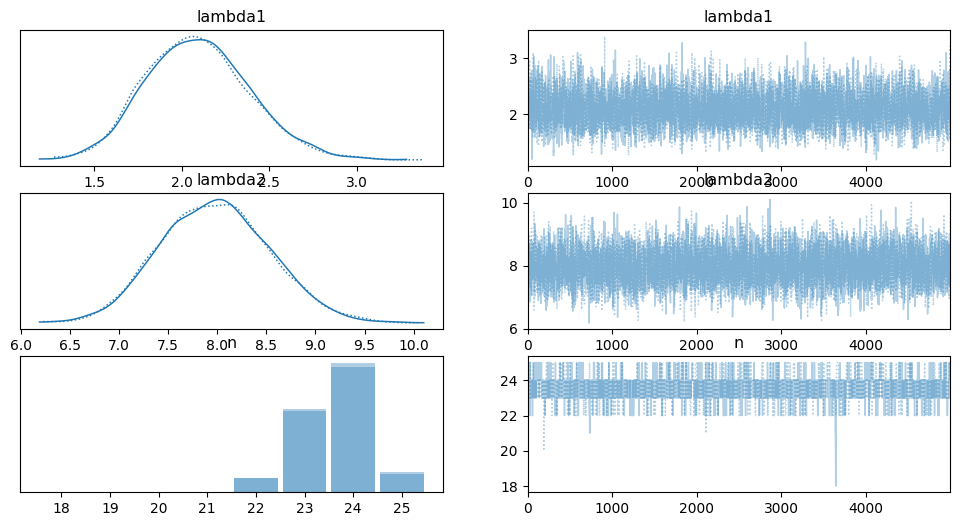

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda1   2.092  0.296   1.547    2.652      0.004    0.003    4989.0   
lambda2   7.979  0.555   6.925    8.983      0.008    0.006    4637.0   
n        23.616  0.733  22.000   25.000      0.019    0.017    1441.0   

         ess_tail  r_hat  
lambda1    5198.0    1.0  
lambda2    5084.0    1.0  
n          1831.0    1.0  
Posterior mean lambda1: 2.0919650999783714
Posterior mean lambda2: 7.978646417212395
Posterior mean n (0 indexed so +1): 23.6155


In [15]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)

N = 50
true_n = 25
true_lambda1 = 2.0
true_lambda2 = 8.0

x = np.concatenate([
    np.random.poisson(true_lambda1, true_n),
    np.random.poisson(true_lambda2, N - true_n)
])

# changepoint model
cp_model = pm.Model()

# set a and b to values used in the paper
a = 2.0
b = 1.0

num_samples = 5000
burn_in = 200

with cp_model:
    # prior for the change-point
    # the change point is equally likely to be anywhere between 0 and N−1
    n = pm.DiscreteUniform("n", lower=0, upper=N-1)

    # priors for lamb1 and lamb2
    lambda1 = pm.Gamma("lambda1", alpha=a, beta=b)
    lambda2 = pm.Gamma("lambda2", alpha=a, beta=b)

    # build the rate vector for the likelihood
    t = np.arange(N)

    # rate will be an array of lambda1 and lambda2 like:
    # [L1, L1, L1, ..., L1, L2, L2, ..., L2]
    rate = pm.math.switch(t <= n, lambda1, lambda2)

    # for each data point x[i], model it as Poisson with the recently calculauted rate
    obs = pm.Poisson("obs", mu=rate, observed=x)

    trace = pm.sample(
        num_samples, # real posterior iterations
        tune=burn_in, # warm up iterations
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=random_seed
    )

# Summary and plots
az.plot_trace(trace)
plt.show()


print(az.summary(trace, var_names=["lambda1", "lambda2", "n"]))

lambda1_mean = trace.posterior["lambda1"].mean().item()
lambda2_mean = trace.posterior["lambda2"].mean().item()
n_mean = trace.posterior["n"].mean().item()

print("Posterior mean lambda1:", lambda1_mean)
print("Posterior mean lambda2:", lambda2_mean)
print("Posterior mean n (0 indexed so +1):", n_mean)

STRETCH GOAL - Implement Gibbs Sampling Algorithm in paper by hand

Starting Gibbs Sampling for 5200 iterations...


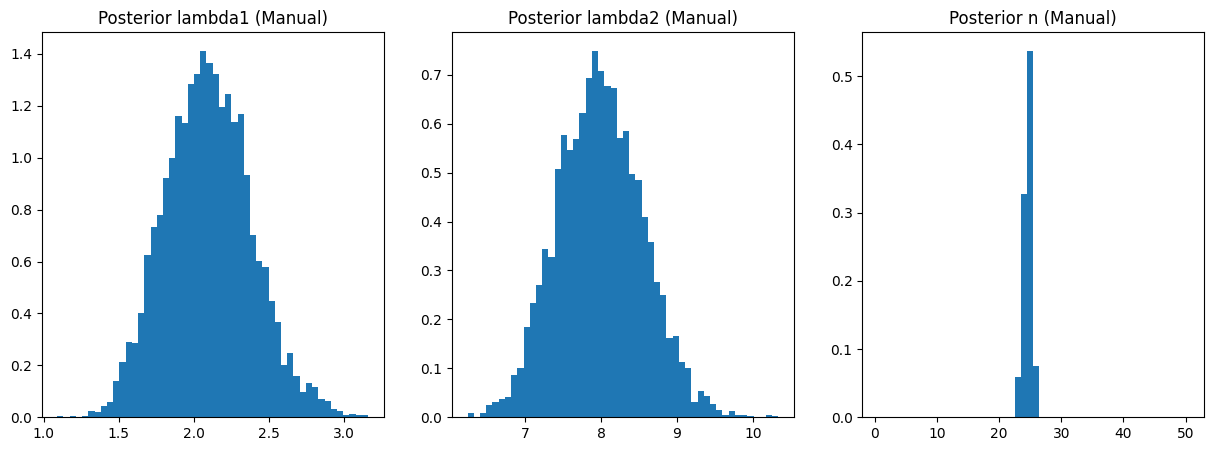

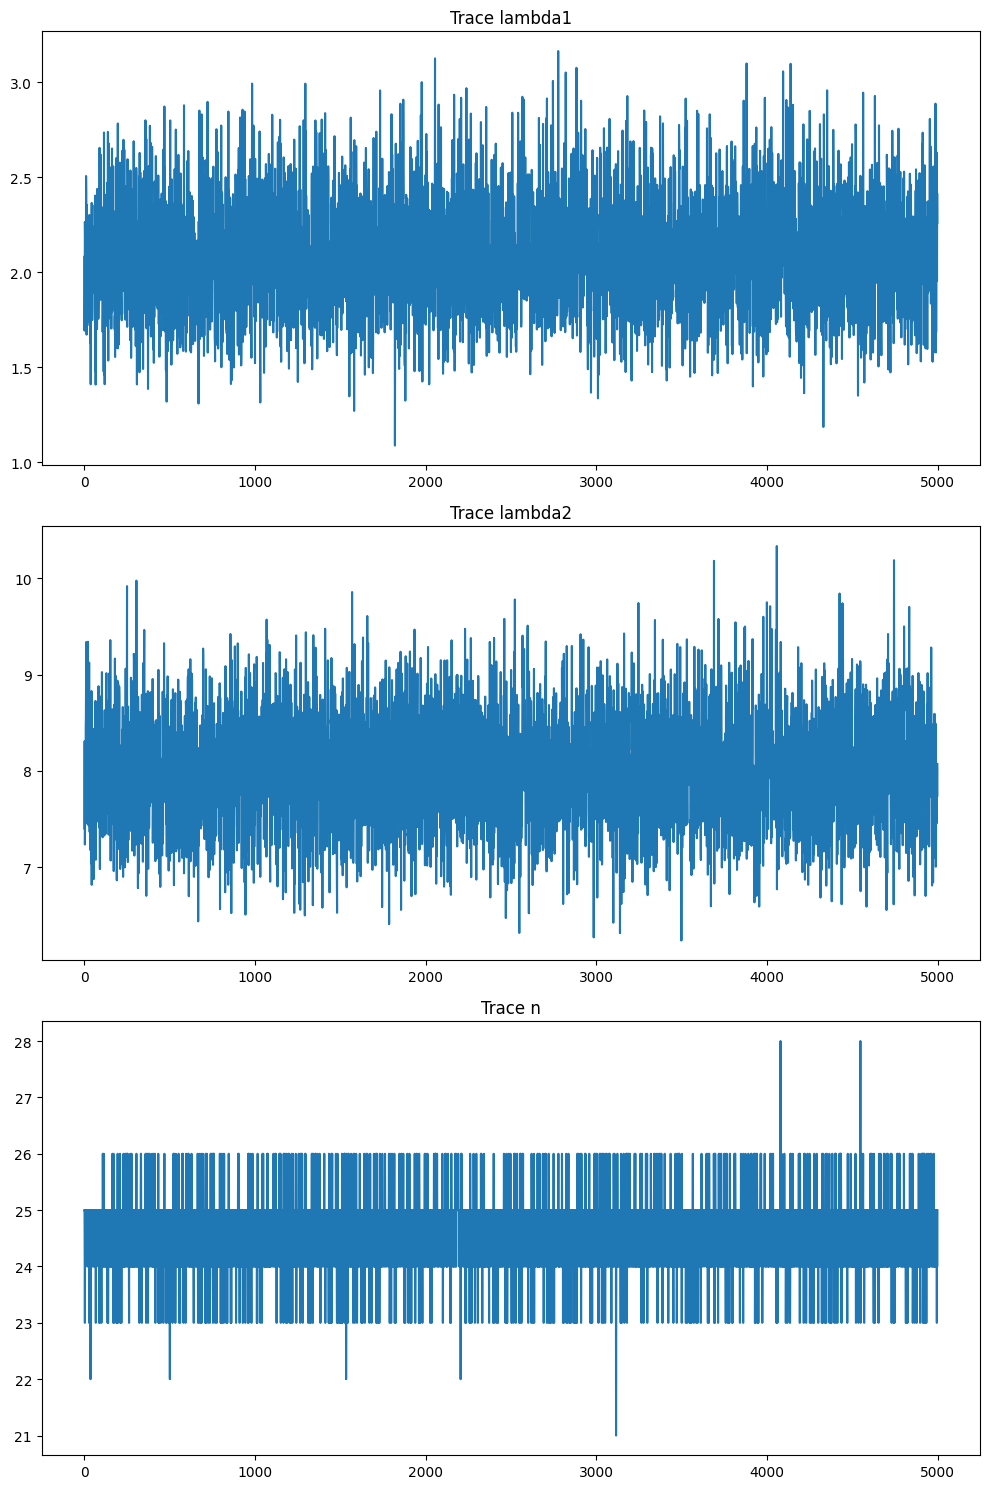

Manual Gibbs:
	Mean lambda1=2.097943202374852
	lambda2=7.988293981556923
	mode n=25


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, poisson, randint

np.random.seed(42)

def manual_gibbs_sampler(x, a, b, n_samples=5000, burn_in=200):
    N = len(x)
    total_iters = n_samples + burn_in

    # storage for results
    results = {
        'lambda1': np.zeros(total_iters),
        'lambda2': np.zeros(total_iters),
        'n': np.zeros(total_iters, dtype=int)
    }

    # initialize variables
    curr_n = np.random.randint(1, N+1) # N+1 so sampler can reach index N
    curr_lambda1 = np.random.gamma(a, 1/b) # (in paper it's b but scipy uses scale=1/b)
    curr_lambda2 = np.random.gamma(a, 1/b)

    print(f"Starting Gibbs Sampling for {total_iters} iterations...")

    for i in range(total_iters):

        # sample lambda1 | n, x
        # posterior is Gamma(a + sum(x_1:n), n + b), equation 8
        sum_x1 = np.sum(x[:curr_n])
        curr_lambda1 = gamma.rvs(a=(a + sum_x1), scale=1.0/(curr_n + b))

        # sample lambda2 | n, x
        # posterior is Gamma(a + sum(x_n+1:N), N - n + b), equation 9
        sum_x2 = np.sum(x[curr_n:])
        curr_lambda2 = gamma.rvs(a=(a + sum_x2), scale=1.0/((N - curr_n) + b))

        # sample n | lambda1, lambda2, x
        # calculate P(n=k | ...) for all possible k in 1..N
        log_probs = np.zeros(N+1)

        # loop through all possible split points
        for k in range(1, N+1):

            # likelihood of first part (indices 0 to k-1) given lambda1
            log_lik_1 = np.sum(poisson.logpmf(x[:k], curr_lambda1))

            # likelihood of second part (indices k to N-1) given lambda2
            log_lik_2 = np.sum(poisson.logpmf(x[k:], curr_lambda2))

            # unnormalized log probability
            log_probs[k] = log_lik_1 + log_lik_2

        # normalize probabilities, ignore k=0 because the paper implies n starts at 1
        log_probs = log_probs[1:]
        prob_values = np.exp(log_probs - np.max(log_probs))
        prob_values /= np.sum(prob_values)

        # sample new n from categorical distribution
        curr_n = np.random.choice(np.arange(1, N + 1), p=prob_values)

        # store results
        results['lambda1'][i] = curr_lambda1
        results['lambda2'][i] = curr_lambda2
        results['n'][i] = curr_n

    # Remove burn-in samples
    return {k: v[burn_in:] for k, v in results.items()}

# same hyperparameters as previous experiment
N = 50
true_n = 25
true_lambda1 = 2.0
true_lambda2 = 8.0

x = np.concatenate([
    np.random.poisson(true_lambda1, true_n),
    np.random.poisson(true_lambda2, N - true_n)
])

# run gibbs sampler
results = manual_gibbs_sampler(x, a=2, b=1, n_samples=5000, burn_in=200)

samples_lambda1 = results['lambda1']
samples_lambda2 = results['lambda2']
samples_n = results['n']

# histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(samples_lambda1, bins=50, density=True)
axs[0].set_title('Posterior lambda1 (Manual)')
axs[1].hist(samples_lambda2, bins=50, density=True)
axs[1].set_title('Posterior lambda2 (Manual)')
axs[2].hist(samples_n, bins=range(1, N+2), density=True, align='left')
axs[2].set_title('Posterior n (Manual)')
plt.show()

# trace plots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(samples_lambda1)
axs[0].set_title('Trace lambda1')
axs[1].plot(samples_lambda2)
axs[1].set_title('Trace lambda2')
axs[2].plot(samples_n)
axs[2].set_title('Trace n')
plt.tight_layout()
plt.show()

# print stats
print(f"Manual Gibbs:\n\tMean lambda1={np.mean(samples_lambda1)}\n\tlambda2={np.mean(samples_lambda2)}\n\tmode n={np.argmax(np.bincount(samples_n))}")